<a href="https://colab.research.google.com/github/dercodeKoenig/colab-KI/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

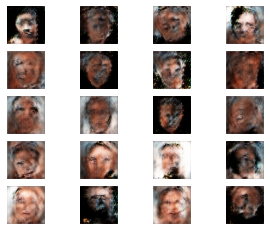

Time for epoch 200 is 33.552000284194946 sec


In [2]:
import os
os.system("git clone https://github.com/dercodeKoenig/faces.git")


import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import numpy as np
import os
from tensorflow.keras import layers
import time
import cv2
from google.colab.patches import cv2_imshow
from IPython import display


train_images = []
z=0
total = len(os.listdir("faces"))
for i in os.listdir("faces"):
  try:
    img = cv2.imread("faces/"+i)
    img = cv2.resize(img, (64,64))
    train_images.append(img)
    z+=1
    print("\r" + str(z) + " / " + str(total),end="")
  except:
    pass
train_images = np.array(train_images,dtype=object)
print("")
print(train_images.shape)

train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

generator = make_generator_model()

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1),input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(64,activation="relu"))

    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 20

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    
    if(epoch % 20 == 0):
      print("save chkp")
      checkpoint.save(file_prefix = checkpoint_prefix)

    display.clear_output(wait=True)
    generate_images(generator,epoch + 1,seed)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

def generate_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  generated_images = np.array(predictions,dtype= 'float32')
  generated_images = (generated_images+1)*127.5
  cz=0

  heighest = 0
  while(True):
      heighest +=1
      if(os.path.exists("outputs/0/"+str(heighest)+".jpg")==False):
        break

  fig = plt.figure(figsize=(10, 10))
  for i in generated_images:
    #print(np.array(i,dtype= 'int32'))
    plt.subplot(4, 5, cz+1)
    plt.imshow(np.array(cv2.cvtColor(i, cv2.COLOR_BGR2RGB),dtype= 'int32'))
    plt.axis('off')
    cv2.imwrite("outputs/"+str(cz)+"/"+str(heighest)+".jpg",i)
    cz+=1
  
  plt.show()

os.system("mkdir outputs")
for i in range(num_examples_to_generate):
  os.system("mkdir outputs/"+str(i))

train(train_dataset, EPOCHS)


In [ ]:
z=1
run=True
while(run):
  time.sleep(0.1)
  
  z2=0
  fig = plt.figure(figsize=(10,10))
  for i in os.listdir("outputs"):
    z2+=1
    try:
      img = cv2.imread("outputs/"+i+"/"+str(z)+".jpg")
      plt.subplot(4,5,z2)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(np.array(img))
      plt.axis('off')
    except:
      run=False
      break
  if(run):  
    display.clear_output(wait=True)
    plt.show()
    z+=1